In [1]:
%run /Users/denis/Documents/Projects/scripts/init.ipy
os.chdir(os.getcwd().replace('/pipeline/notebooks', ''));

### 1. Get Enrichr counts

In [2]:
# Make counts
count_dataframe = pd.read_feather('./feather.dir/list_off_co.feather').set_index('gene_symbol')

# Get counts
gene_count_dataframe = pd.Series(np.diag(count_dataframe), index=count_dataframe.index, name='counts').to_frame()
gene_count_dataframe.head()

/Users/denis/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning:

`nthreads` argument is deprecated, pass `use_threads` instead



counts
gene_symbol        
A1BGAS1         821
A1CF           2776
A2M            8431
A2ML1          2677
A2MP1           324

### 2. Get annotations

In [3]:
def readGMT(infile):
    gmt = {}
    with open(infile) as openfile:
        for line in openfile.read().split('\n'):
            split_line = line.strip().split('\t')
            if split_line[0]:
                gmt[split_line[0]] = [x.split(',')[0] for x in split_line[2:]]
    return gmt

In [8]:
# Calculate
calculate = False

# Check if calculate
if calculate:
    # Get GMT
    gmt_files = glob.glob('./libraries.dir/*.txt')

    # Read GMTs
    libraries = {os.path.basename(gmt_file)[:-len('.txt')]: readGMT(gmt_file) for gmt_file in gmt_files}
    libraries_merged = {library_name: [gene for term_genes in gmt.values() for gene in term_genes] for library_name, gmt in libraries.items()}

    # Get counts
    gmt_counts = {library_name: {gene: genes_merged.count(gene) for gene in gene_count_dataframe.index} for library_name, genes_merged in libraries_merged.items()}

    # Convert to dataframe
    gmt_count_dataframe = pd.DataFrame(gmt_counts)
    
    # Write
    gmt_count_dataframe.to_csv('./rawdata.dir/gmt_counts_new.txt', sep='\t')
else:
    # Read
    gmt_count_dataframe = pd.read_table('./rawdata.dir/gmt_counts_new.txt', index_col='Unnamed: 0')

print(gmt_count_dataframe.shape)
gmt_count_dataframe.head()

(23568, 15)


GO_Molecular_Function_2018  ARCHS4_TFs_Coexp  huMAP  Reactome_2016  \
A1BGAS1                           0                 0      0              0   
A1CF                              2                26      0              1   
A2M                               6                16      0             16   
A2ML1                             1                18      0              0   
A2MP1                             0                 4      0              0   

         WikiPathways_2016  ARCHS4_Kinases_Coexp  KEGG_2016  \
A1BGAS1                  0                     0          0   
A1CF                     0                     6          0   
A2M                      1                    11          1   
A2ML1                    0                     3          0   
A2MP1                    0                     0          0   

         GO_Biological_Process_2018  MGI_Mammalian_Phenotype_Level_4  SCP  \
A1BGAS1                           0                                0    0   
A1CF                              3                                2    4   
A2M                               8                                0    4   
A2ML1                             2                                0    1   
A2MP1                             0                                0    0   

         GO_Cellular_Component_2018  LINCS_L1000_Kinase_Perturbations_down  \
A1BGAS1                           0                                      0   
A1CF                              0                                     60   
A2M                               3                                     37   
A2ML1                             0                                      0   
A2MP1                             0                                      0   

         ChEA_2016  LINCS_L1000_Kinase_Perturbations_up  \
A1BGAS1          0                                    0   
A1CF            29                                    9   
A2M             23                                   33   
A2ML1           22                                    0   
A2MP1            0                                    0   

         ENCODE_TF_ChIPseq_2015  
A1BGAS1                       0  
A1CF                          7  
A2M                          27  
A2ML1                        15  
A2MP1                         5

### 3. Merge

In [9]:
# Prepare for plotting
merged_dataframe = gene_count_dataframe.merge(gmt_count_dataframe, left_index=True, right_index=True)
plot_dataframe = pd.melt(merged_dataframe.rename_axis('gene_symbol').reset_index(), id_vars=['gene_symbol', 'counts'])
print(plot_dataframe.shape)
plot_dataframe.head()

(353520, 4)


gene_symbol  counts                    variable  value
0     A1BGAS1     821  GO_Molecular_Function_2018      0
1        A1CF    2776  GO_Molecular_Function_2018      2
2         A2M    8431  GO_Molecular_Function_2018      6
3       A2ML1    2677  GO_Molecular_Function_2018      1
4       A2MP1     324  GO_Molecular_Function_2018      0

### 4. Annotated vs Unannotated Horizontal Boxplot

/Users/denis/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



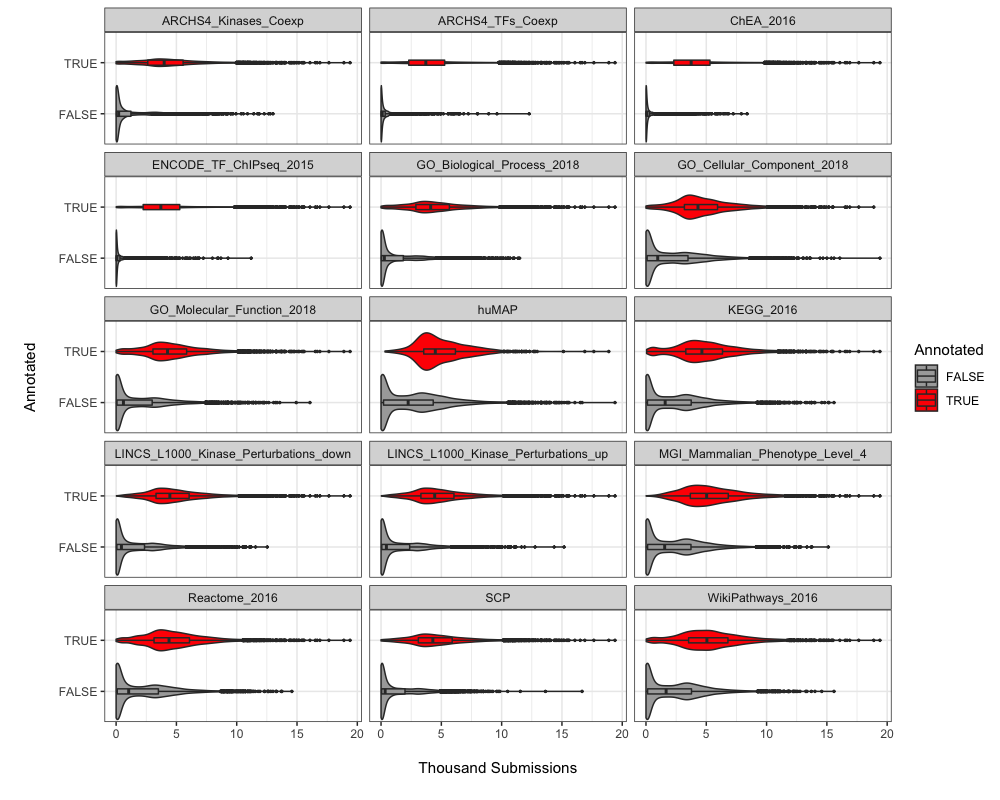

In [10]:
%%R -i plot_dataframe -h 800 -w 1000 -r 100
ggplot(plot_dataframe, aes(x=value>0, y=counts/1000, fill=value>0)) +
geom_violin(width=1.1) +
geom_boxplot(width=.1, outlier.size=.5) +
facet_wrap(~variable, nrow=5) +
scale_fill_manual('Annotated', values=c('darkgrey', 'red')) + 
coord_flip() + 
#scale_fill_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
#scale_color_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
# scale_y_log10() +
#scale_x_continuous(lim=c(,), breaks=ticks, labels=ticks) +
#scale_y_continuous(lim=c(,), breaks=ticks, labels=ticks) +
#ggtitle('') +
ylab('\nThousand Submissions\n') +
xlab('\nAnnotated\n') +
theme_bw()

### 5. Libraries Vertical Boxplot

In [13]:
library_count_dataframe = plot_dataframe.query('value > 0').groupby(['gene_symbol', 'counts']).size().rename('libraries_annotated').to_frame().reset_index()
library_count_dataframe.head()

gene_symbol  counts  libraries_annotated
0        A1CF    2776                   11
1         A2M    8431                   13
2       A2ML1    2677                    7
3       A2MP1     324                    2
4     A3GALT2    1322                    6

/Users/denis/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



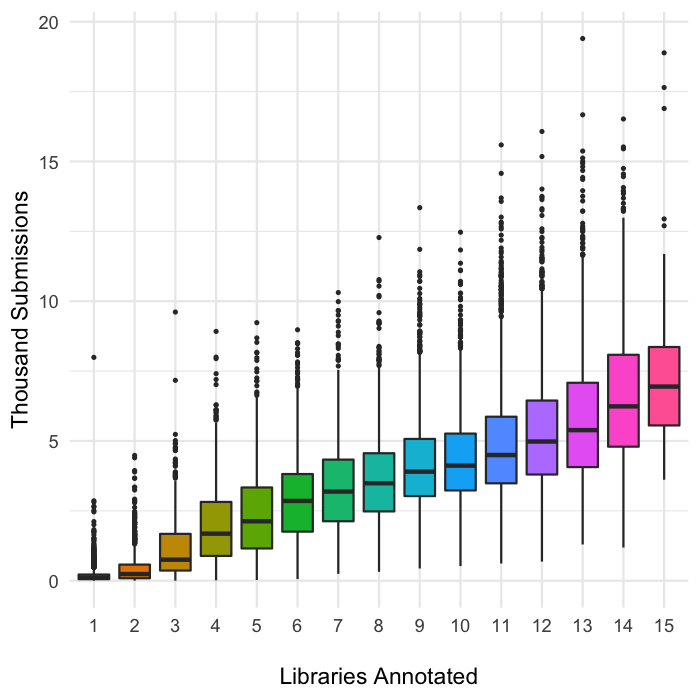

In [14]:
%%R -i library_count_dataframe -h 700 -w 700 -r 150
ggplot(library_count_dataframe, aes(x=as.factor(libraries_annotated), y=counts/1000, fill=as.factor(libraries_annotated))) +
# geom_violin(width=1.5) +
# geom_boxplot(width=.1) +
geom_boxplot(width=.75, outlier.size=0.5) +
#facet_wrap(~) +
#scale_fill_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
#scale_color_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
#scale_x_continuous(lim=c(,), breaks=ticks, labels=ticks) +
#scale_y_continuous(lim=c(,), breaks=ticks, labels=ticks) +
#ggtitle('') +
xlab('\nLibraries Annotated') +
ylab('Thousand Submissions') +
theme_minimal() + guides(fill=FALSE)

### 6. Occurrence vs Terms Scatter Plot

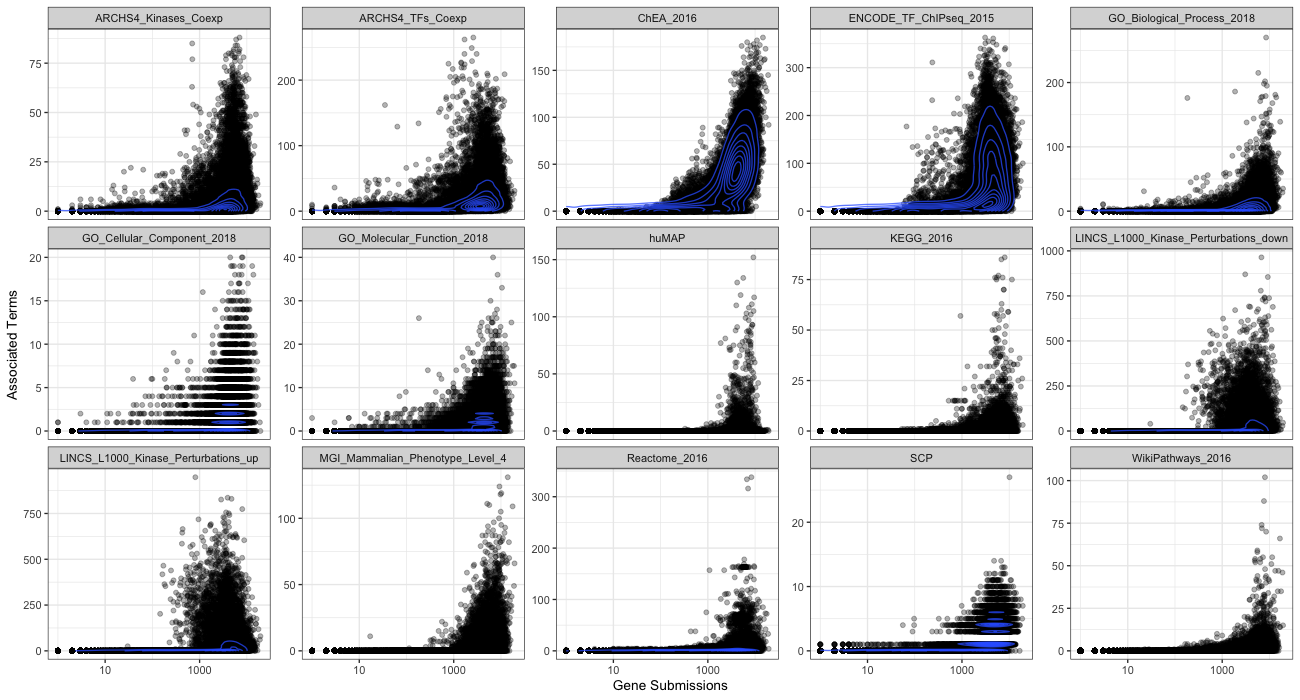

In [15]:
%%R -i plot_dataframe -h 700 -w 1300 -r 90
ggplot(plot_dataframe, aes(x=counts, y=value)) +
    geom_point(alpha=0.3) + 
    scale_x_log10() + 
    geom_density2d(alpha=0.75) + 
    facet_wrap(~variable, scales='free_y', ncol=5) +
    theme_minimal() + 
    xlab('Gene Submissions') + 
    ylab('Associated Terms')